In [32]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, votable
from astropy.table import Table, vstack, hstack
import os, sys
from astropy.io import fits

## 1. MMDD crossmatch

### convert into .npy (3 lines lacking icrsra information excluded)

In [1398]:
MWDD = Table.read('WD_MWDD-export.csv')
MWDD = MWDD[MWDD['icrsra'].mask==False]
(MWDD['icrsra'].mask==True).sum()
print(len(MWDD))
MWDD_ra = np.empty(len(MWDD))
MWDD_dec = np.empty(len(MWDD))
for i in range(len(MWDD)):
    MWDD_ra[i] = 15 * (int(MWDD['icrsra'][i][0:2]) +int(MWDD['icrsra'][i][3:5])/60 + float(MWDD['icrsra'][i][6:])/3600)
    if MWDD['icrsdec'][i][0] == '-':
        MWDD_dec[i] = -1* (int(MWDD['icrsdec'][i][1:3]) + int(MWDD['icrsdec'][i][4:6])/60 +  float(MWDD['icrsdec'][i][7:])/3600)
    else:   
        MWDD_dec[i] = (int(MWDD['icrsdec'][i][0:2]) + int(MWDD['icrsdec'][i][3:5])/60 +  float(MWDD['icrsdec'][i][6:])/3600)
MWDD['ra'] = MWDD_ra
MWDD['dec'] = MWDD_dec
np.save('WD_MWDD.npy',np.array([{'MWDD':MWDD}]))

36961


In [1423]:
MWDD[15219]

<Row index=15219 masked=True>
          wdid                      name              icrsra     icrsdec   spectype   teff   Dteff    logg   Dlogg    mass   Dmass  ismag    su      sg      sr      si      sz    nbUV nbOpt       ra           dec     
         str30                     str25              str11       str12     str72   float64 float64 float64 float64 float64 float64  str3 float64 float64 float64 float64 float64 int64 int64    float64       float64   
------------------------ ------------------------- ----------- ----------- -------- ------- ------- ------- ------- ------- ------- ----- ------- ------- ------- ------- ------- ----- ----- ------------- -------------
SDSS J103624.73+510030.9 SDSS J103624.73+510030.95 10 36 24.74 51 00 30.59      DA:  7737.0   271.0     8.0     1.0      --      --    --  21.382  20.897  20.764   20.71  20.698     0     1 159.103083333 51.0084972222

### load npy

In [1401]:
MWDD = np.load('WD_MWDD.npy')[0]['MWDD']
#MMDD.sort('dec')

In [1402]:
WD_sdss = np.load('WD_table_sdss.npy')[0]['table']
Gaia_xmatch_sdss = np.load('WD_table_sdss.npy')[0]['sdss']
WD_sdss['index'] = np.arange(len(WD_sdss))
len(WD_sdss)

18495

In [1422]:
Gaia_xmatch_sdss[np.where(WD_sdss['source_id']==1617015089130028544)]# 68083

<Table masked=True length=1>
sdssdr9_oid        obj_id        thing_id ...      source_id      index
                                          ...                          
   int64           object         int64   ...        int64        int64
----------- ------------------- --------- ... ------------------- -----
  441315500 1237654398627152025 523650732 ... 1617015089130028544 68083

### cross-matching

In [1403]:
WD_sdss['MWDD_index'] = np.zeros(len(WD_sdss),dtype=int)
WD_sdss['MWDD_d'] = np.zeros(len(WD_sdss),dtype=float)

In [1404]:
for i in range(len(WD_sdss)):
    d = np.sqrt(((WD_sdss[i]['ra'] - MWDD['ra']) * np.cos(WD_sdss[i]['dec']/180*np.pi) - WD_sdss[i]['pmra']*15/3600000 )**2 + 
            (WD_sdss[i]['dec'] - WD_sdss[i]['pmdec']*15/3600000- MWDD['dec'] )**2 )
    WD_sdss['MWDD_index'][i] = np.where(d == d.min())[0][0]
    WD_sdss['MWDD_d'][i] = d.min() * 3600

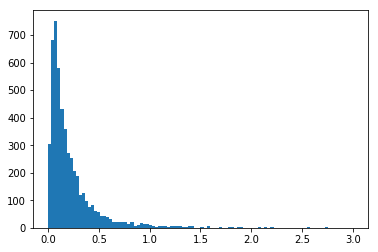

In [1406]:
plt.hist(WD_sdss['MWDD_d'],100,(0,3))
plt.show()

In [1407]:
WD_sdss['MWDD_r'] = MWDD['sr'][WD_sdss['MWDD_index']]
WD_sdss['MWDD_u'] = MWDD['su'][WD_sdss['MWDD_index']]
WD_sdss['MWDD_g'] = MWDD['sg'][WD_sdss['MWDD_index']]
WD_sdss['MWDD_i'] = MWDD['si'][WD_sdss['MWDD_index']]
WD_sdss['nbOpt'] = MWDD['nbOpt'][WD_sdss['MWDD_index']]
WD_sdss['ismag'] = MWDD['ismag'][WD_sdss['MWDD_index']]
WD_sdss['spectype'] = MWDD['spectype'][WD_sdss['MWDD_index']]
WD_sdss['m_M'] = 5 * np.log10(1/WD_sdss['parallax']*1000) - 5
WD_sdss['name'] = MWDD['name'][WD_sdss['MWDD_index']]
WD_sdss['teff'] = MWDD['teff'][WD_sdss['MWDD_index']]
WD_sdss['Dteff'] = MWDD['Dteff'][WD_sdss['MWDD_index']]
WD_sdss['logg'] = MWDD['logg'][WD_sdss['MWDD_index']]
WD_sdss['Dlogg'] = MWDD['Dlogg'][WD_sdss['MWDD_index']]
WD_sdss['mass'] = MWDD['mass'][WD_sdss['MWDD_index']]
WD_sdss['Dmass'] = MWDD['Dmass'][WD_sdss['MWDD_index']]
WD_sdss['ismag_more'] = np.zeros(len(WD_sdss),bool)
for i in range(len(WD_sdss)):
    WD_sdss['ismag_more'][i] = ('H' in WD_sdss[i]['spectype']) and ('H:' not in WD_sdss[i]['spectype'])
np.save('WD_table_sdss.npy',np.array([{'table':WD_sdss,'sdss':Gaia_xmatch_sdss}])) ## transport this to local computer

In [1419]:
Gaia_xmatch_sdss[0]

<Row index=0 masked=True>
sdssdr9_oid        obj_id       thing_id         ra                 dec               ra_error            dec_error         mjd     u_mag       u_mag_error            g_mag            g_mag_error            r_mag            r_mag_error            i_mag            i_mag_error        z_mag       z_mag_error      objc_type clean_flag        sdss_d             source_id      index
                                                deg                 deg                 arcs                 arcs            d       mag            mag                 mag                 mag                 mag                 mag                 mag                 mag             mag            mag                                       arcs                                  
   int64           object        int64        float64             float64             float64              float64        float64  float64        float64             float64             float64             float64             float64             float64             float64         float64        float64          int32     int32          float64               int64        int64
----------- ------------------- -------- ------------------ ------------------- ------------------- --------------------- ------- --------- -------------------- ------------------ -------------------- ------------------ -------------------- ------------------ -------------------- --------- -------------------- --------- ---------- -------------------- ------------------- -----
   51977043 1237655691943936384 61494019 230.67607674514039 -2.1120206180517656 0.00434732875743837 0.0042661940449236456 52075.0 19.320719 0.032838825000000002 18.861025000000001 0.018476946000000001 18.703983000000001 0.012248355000000001 18.667407999999998 0.014552972000000001 18.727594 0.034804143000000003         6          1 0.060458990492979266 4415230812694612864    16

In [1529]:
small_d = (WD_sdss['MWDD_d']<2) * (WD_sdss['nbOpt']>0)
(small_d).sum()

4826

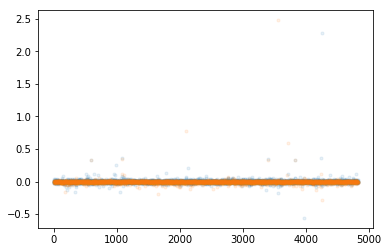

In [1430]:
plt.plot(WD_sdss['MWDD_u'][small_d]-Gaia_xmatch_sdss['u_mag'][small_d],'.',alpha=0.1)
plt.plot(WD_sdss['MWDD_r'][small_d]-Gaia_xmatch_sdss['r_mag'][small_d],'.',alpha=0.1)
plt.show()

## 2. spectral files: create spec.npy

to continue from the cell on server,
1. then download the csv file and upload it to Casjob (finished)
2. match the obj_id with SEGUE list and get PLATE, MJD, FIBERID (finished)
3. download from Casjob in .csv format (finished)
4. change the null into empty (to be done below)
5. upload the non-null PLATE, MJD, FIBERID to SEGUE spec query (limit of 1000 for each time) https://dr14.sdss.org/optical/spectrum/search

### download spectra from SAS to dslogin01 or local

In [1493]:
spec_boss = Table.read('WD_spec_boss.csv',format='csv')
spec_segue = Table.read('WD_spec_segue.csv',format='csv')
spec_sdss = Table.read('WD_spec_sdss.csv',format='csv')
spec_dr14 = Table.read('WD_spec_DR14.csv',format='csv')
spec_legacy = Table.read('WD_spec_legacy.csv',format='csv')
#table.remove_rows(np.where(table['index1'][1:]-table['index1'][:-1] == 0))
len(spec_boss), len(WD_sdss)

(18495, 18495)

In [1495]:
table = spec_legacy
with_spec = table['MJD']!='null'
print(with_spec.sum())
table[np.where(table['obj_id']==1237654398627152025)[0][0]]
#table[with_spec][0]

3246


<Row index=17155>
       obj_id        MJD  PLATE FIBERID     ra       dec    index1
       int64         str5  str4   str4    str10     str13   int64 
------------------- ----- ----- ------- --------- --------- ------
1237654398627152025 52081   608      85 221.78092 58.918541  68083

### download spectra by plate, mjd and fiber to dslogin01

In [1517]:
def gen_download_command(table,code='26',name='legacy'):
    with_spec = table['MJD']!='null'
    download_command = '#!bash\n'
    for i in range(with_spec.sum()):
        PLATE = '%04i' % int(table['PLATE'][with_spec][i])
        MJD = '%05i' % int(table['MJD'][with_spec][i])
        FIBER = '%04i' % int(table['FIBERID'][with_spec][i])

        download_command+='wget -P /datascope/menard/group/scheng/Gaia/WD_spectra_'+\
        name+'/ https://data.sdss.org/sas/dr14/sdss/spectro/redux/'+code+\
        '/spectra/lite/'+PLATE+'/spec-'+PLATE+'-'+MJD+'-'+FIBER+'.fits\n'
    return download_command, with_spec

In [1518]:
download_legacy, with_spec_legacy = gen_download_command(spec_legacy,'26','legacy')
download_boss, with_spec_boss = gen_download_command(spec_boss,'v5_10_0','boss')
download_segue, with_spec_segue = gen_download_command(spec_segue,'104','segue')
f = open('WD_download_legacy.bash','w')
f.write(download_legacy)
f.close()
f = open('WD_download_boss.bash','w')
f.write(download_boss)
f.close()
f = open('WD_download_segue.bash','w')
f.write(download_segue)
f.close()

In [1521]:
with_spec_boss.sum()+with_spec_legacy.sum()-(with_spec_boss*with_spec_legacy).sum()

4831

1. save a bash file with header #!bash and add wget to each line.
2. execute the bash file to download spectral files from SDSS. (to the dslogin01 server)
3. move back to dslogin01 server to work

## download spec.npy (finished)
scp scheng@dslogin01.pha.jhu.edu:/home/scheng/Gaia/WD_spec_unnorm.npy .

In [867]:
from scipy.interpolate import interp1d
import os
from astropy.io import fits
from scipy.signal import medfilt

dir_WD_spectra = '/datascope/menard/group/scheng/Gaia/WD_spectra_all/'
name_list = os.listdir(dir_WD_spectra)
def open_one_spec_by_name_list(i,med_size=3,pl=True):
    name = name_list[i]
    hdul = fits.open(dir_WD_spectra+name)
    lam = 10**hdul[1].data['loglam']
    flux = hdul[1].data['flux']
    flux_med = medfilt(flux,med_size)
    func = interp1d(lam, flux_med, kind='linear', bounds_error=False, fill_value=(flux[0],flux[-1]), assume_sorted=True)
    lam_grid = lam_standard
    if pl==True:
        plt.figure(figsize=(18,6))
        plt.plot(lam_grid,func(lam_grid))
        plt.axvline(6563)
        plt.axvline(3646)
        plt.show()
    return lam_grid, func(lam_grid)

def open_one_spec(i,med_size=3,pl=True):
    name = 'spec-'+'%04i' % (int(table['PLATE'][i])) + '-' + '%5i' % (int(table['MJD'][i])) + '-' +\
                '%04i' % (int(table['FIBERID'][i]))+'.fits'
    
    hdul = fits.open(dir_WD_spectra+name)
    lam = 10**hdul[1].data['loglam']
    flux = hdul[1].data['flux']
    flux_med = medfilt(flux,med_size)
    func = interp1d(lam, flux_med, kind='linear', bounds_error=False, fill_value=(flux[0],flux[-1]), assume_sorted=True)
    lam_grid = lam_standard
    if pl==True:
        plt.figure(figsize=(18,6))
        plt.plot(lam_grid,func(lam_grid))
        plt.axvline(6563)
        plt.axvline(3646)
        plt.show()
    return lam_grid, func(lam_grid)

### load npy spec

In [1010]:
data = np.load('WD_spec_unnorm.npy')[0]
spec = data['spec']
lam_standard = data['lam_standard']
name_list = data['name_list']

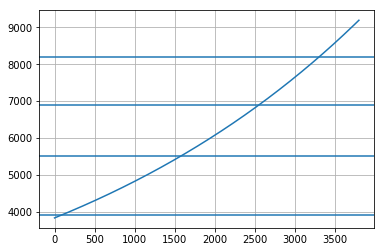

In [1013]:
plt.plot(lam_standard)
plt.axhline(3900)
plt.axhline(5500)
plt.axhline(6900)
plt.axhline(8200)
plt.grid()
plt.show()
g_band = np.arange(0,1500)
r_band = np.arange(1500,2500)
i_band = np.arange(2500,3250)
z_band = np.arange(3250,len(lam_standard))

In [1279]:
WD_with_spec = WD_sdss[with_spec]
WD_with_spec['spec_g'] = -2.5*np.log10(spec[:,g_band].sum(axis=1))
WD_with_spec['spec_r'] = -2.5*np.log10(spec[:,r_band].sum(axis=1))
WD_with_spec['spec_i'] = -2.5*np.log10(spec[:,i_band].sum(axis=1))
WD_with_spec['spec_z'] = -2.5*np.log10(spec[:,z_band].sum(axis=1))
WD_with_spec['spec_bp'] = -2.5*np.log10(spec[:,0:2300].sum(axis=1))
WD_with_spec['spec_rp'] = -2.5*np.log10(spec[:,2200:].sum(axis=1))
WD_with_spec['spec_G'] = -2.5*np.log10(spec[:,:].sum(axis=1))

/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing th

### spectral color validation

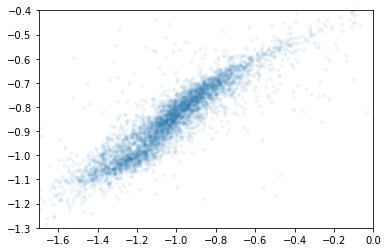

In [1026]:
plt.plot(WD_with_spec['spec_g'] - WD_with_spec['spec_r'], WD_with_spec['spec_r']-WD_with_spec['spec_i'],'.',alpha=0.05)
plt.xlim(-1.7,0)
plt.ylim(-1.3,-0.4)
plt.show()

### MWDD, Gaia, and spectral color validation

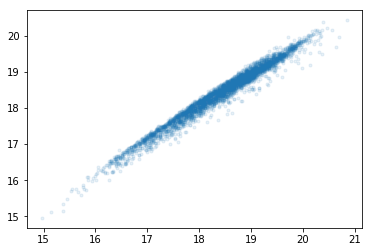

In [1035]:
#plt.plot(WD_with_spec['MMDD_g'],WD_with_spec['spec_g'],'.',alpha=0.1)
plt.plot(WD_with_spec['MMDD_g'][WD_with_spec['MMDD_d']<1],\
         WD_with_spec['phot_g_mean_mag'][WD_with_spec['MMDD_d']<1],'.',alpha=0.1)
plt.show()

In [1304]:
WD_with_spec[0]

<Row index=0 masked=True>
    solution_id             designation               source_id      random_index ref_epoch         ra               ra_error              dec             dec_error           parallax         parallax_error   parallax_over_error         pmra             pmra_error            pmdec            pmdec_error     ra_dec_corr  ra_parallax_corr ra_pmra_corr ra_pmdec_corr dec_parallax_corr dec_pmra_corr dec_pmdec_corr parallax_pmra_corr parallax_pmdec_corr pmra_pmdec_corr astrometric_n_obs_al astrometric_n_obs_ac astrometric_n_good_obs_al astrometric_n_bad_obs_al astrometric_gof_al astrometric_chi2_al astrometric_excess_noise astrometric_excess_noise_sig astrometric_params_solved astrometric_primary_flag astrometric_weight_al astrometric_pseudo_colour astrometric_pseudo_colour_error mean_varpi_factor_al astrometric_matched_observations visibility_periods_used astrometric_sigma5d_max frame_rotator_object_type matched_observations duplicated_source phot_g_n_obs  phot_g_mean_flux  phot_g_mean_flux_error phot_g_mean_flux_over_error phot_g_mean_mag phot_bp_n_obs phot_bp_mean_flux phot_bp_mean_flux_error phot_bp_mean_flux_over_error phot_bp_mean_mag phot_rp_n_obs phot_rp_mean_flux phot_rp_mean_flux_error phot_rp_mean_flux_over_error phot_rp_mean_mag phot_bp_rp_excess_factor phot_proc_mode   bp_rp       bp_g       g_rp    radial_velocity radial_velocity_error rv_nb_transits rv_template_teff rv_template_logg rv_template_fe_h phot_variable_flag          l                  b               ecl_lon            ecl_lat       priam_flags teff_val teff_percentile_lower teff_percentile_upper a_g_val a_g_percentile_lower a_g_percentile_upper e_bp_min_rp_val e_bp_min_rp_percentile_lower e_bp_min_rp_percentile_upper flame_flags radius_val radius_percentile_lower radius_percentile_upper lum_val lum_percentile_lower lum_percentile_upper                                  datalink_url                                 epoch_photometry_url index MMDD_index     MMDD_d      MMDD_r  MMDD_u   MMDD_g   MMDD_i  nbOpt ismag spectype        m_M                   name           ismag_more   teff   Dteff    logg   Dlogg    mass   Dmass      spec_g         spec_r         spec_i         spec_z        spec_bp        spec_rp         spec_G    
                                                                                      yr           deg                 mas                 deg                mas                mas                 mas                                  mas.yr**-1          mas.yr**-1          mas.yr**-1          mas.yr**-1                                                                                                                                                                                                                                                                                                                  mas                                                                                                   mas**-2                  um**-1                       um**-1                                                                                                     mas                                                                                          'electron'.s**-1     'electron'.s**-1                                      mag                      'electron'.s**-1     'electron'.s**-1                                       mag                       'electron'.s**-1     'electron'.s**-1                                       mag                                                   mag        mag        mag         km.s**-1           km.s**-1                             K          log(cm.s**-2)        'dex'                                  deg                deg                deg                deg                        K               K                     K             mag           mag                  mag                mag                   mag                          mag                             Rsun     

## split in WD sequence

In [1322]:
def plot_HR(table,func,func_select,plt_list,pl_only_all=False,plot_type='HR',plt_box=True):
    ismag = (table['ismag'].mask==False) + (table['ismag_more']==True)
    DA = table['spectype'] == 'DA'
    DB = table['spectype'] == 'DB'
    DQ = (table['spectype'] == 'DQ') | (table['spectype'] == 'DQ_CI')
    DC = table['spectype'] == 'DC'
    DZ = table['spectype'] == 'DZ'
    others = ~DA*~DB*~DC*~DQ
    
    plt.figure(figsize=(12,6))
    if plot_type == 'HR':
        x = (table['bp_rp'])#(table['spec_g']) - table['spec_r']#
        y = (table['phot_g_mean_mag']-table['m_M'])
        plt.ylim(16,8)
        plt.xlim(-0.6,1.25)
        plt.xlabel('bp - rp')
        plt.ylabel('G')
    if plot_type == 'CC':
        x = (table['bp_rp'])
        y = (table['MMDD_u']) - table['MMDD_g']
        plt.xlim(-0.6,1.25)
        plt.ylim(-0.7,2)
        plt.xlabel('bp - rp')
        plt.ylabel('u - g')
        #x = (table['phot_bp_mean_mag']) - table['phot_g_mean_mag']
        #y = (table['phot_g_mean_mag']) - table['phot_rp_mean_mag']
        #plt.xlim(-0.4,0.8); plt.ylim(-0.4,0.8); plt.xlabel('BP - G'); plt.ylabel('G - RP')
    if plot_type == 'Var':
        phot_noise_excess = table['phot_g_mean_flux_error']*4.4/(table['phot_g_mean_flux']*4.4/table['phot_g_n_obs'])**0.5
        x = table['bp_rp']
        #z = table['phot_g_mean_mag']
        y = phot_noise_excess    
        plt.ylim(0,10)
        plt.xlim(-1,1.7)
        plt.xlabel('bp - rp')
        plt.ylabel('photometric noise excess ( std_obs / std_poission )')
    
    if pl_only_all != False:
        if pl_only_all == True:
            plt.plot(x,y,'.',alpha=0.1)
        else:
            plt.scatter(x,y,c=table[pl_only_all],s=1,vmin=np.percentile(table[pl_only_all],10),\
                        vmax=np.percentile(table[pl_only_all],90))
            plt.colorbar()
            plt.title(pl_only_all)
        if plt_box==True:
            plt.plot([xmin, xmin, xmax, xmax, xmin],\
                     [func(xmin,offset,slope)-width,func(xmin,offset,slope)+width,func(xmax,offset,slope)+width,func(xmax,offset,slope)-width,\
                      func(xmin,offset,slope)-width ])
        plt.grid()
        plt.show()
        return True
    else:
        plt.plot(x,y,'.',alpha=0.1)
        if 'DA' in plt_list:
            plt.plot(x[DA],y[DA],'.',label='DA',alpha=0.1)
        if 'DB' in plt_list:
            plt.plot(x[DB],y[DB],'.',label='DB')
        if 'DQ' in plt_list:
            plt.plot(x[DQ],y[DQ],'.',label='DQ')
        if 'DC' in plt_list:
            plt.plot(x[DC],y[DC],'.',label='DC')
        if 'DZ' in plt_list:
            plt.plot(x[DZ],y[DZ],'.',label='DZ')
        #plt.plot(x[others],y[others],'.',label='other')
        if 'mag' in plt_list:
            plt.plot(x[ismag],y[ismag],'.y',label='magnetic',markersize=15,alpha=0.3)
        plt.legend()
        if plt_box == True:
            plt.plot([xmin, xmin, xmax, xmax, xmin],\
                     [func(xmin,offset,slope)-width,func(xmin,offset,slope)+width,func(xmax,offset,slope)+width,func(xmax,offset,slope)-width,\
                      func(xmin,offset,slope)-width ])
        selected = func_select(x,y,offset,slope,width,xmin,xmax)
        #plt.plot(x[selected],y[selected],'.',label='selected')
        plt.grid()
        plt.show()
        return selected

In [1247]:
xmin = -0.40
xmax = 0.10
offset = 13.1
width = 0.20
slope = 1
func = lambda x, offset, slope: offset+x*slope
func_select = lambda x, y, offset, slope, width, xmin, xmax: (np.abs(offset+x*slope-y)<width) * (x>xmin) * (x<xmax)

### MMDD

In [1109]:
high_snr = (WD_sdss['parallax_over_error']>30) * (WD_sdss['m_M']<5)

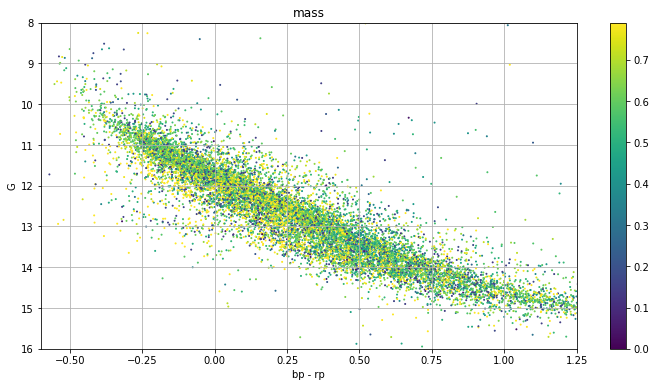

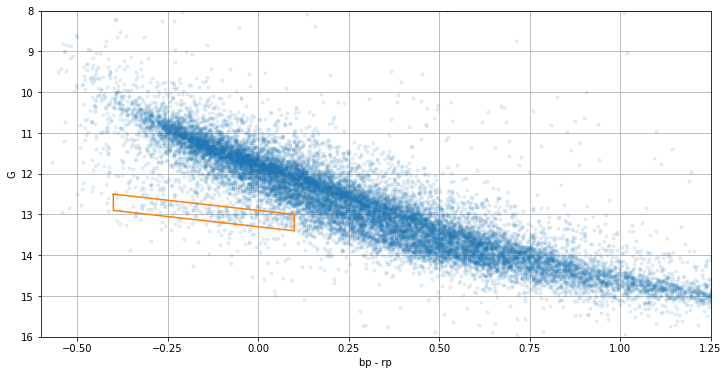

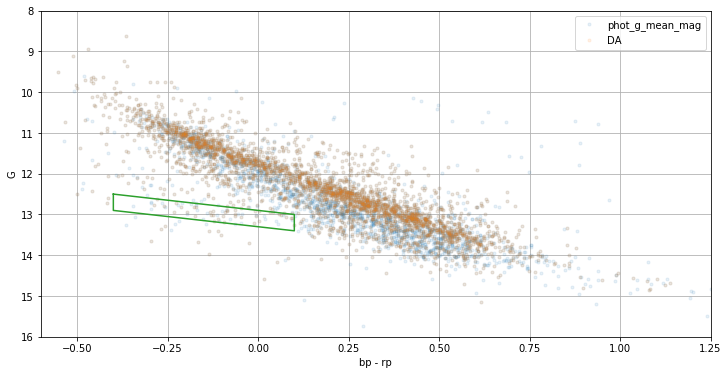

In [1324]:
plt_list = ['DA']
plot_HR(WD_sdss,func,func_select,plt_list,'mass',plt_box=False)
plot_HR(WD_sdss,func,func_select,plt_list,True,plt_box=True)
selected_low_MMDD = plot_HR(WD_sdss[small_d],func,func_select,plt_list)

In [1039]:
for i in range(selected_low_MMDD.sum()):
    print(WD_sdss[small_d][selected_low_MMDD]['name'][i])

KUV 08084+4221
SDSS J110752.87-160705.4
SDSS J090707.34+253313.46
SDSS_J004705.83-004819.6
SDSS J114851.68-012612.8
SDSS J090632.66+080716.0
SDSS J110005.06+602330.9
SDSS J110735.32+085924.5
SDSS J151314.08+545420.5
SDSS_J133340.33+640627.3
SDSS J113359.94+633113.2
SDSS J133420.97+041751.1
SDSS J225828.49+280829.04
SDSS J091440.38+111336.2
SDSS_J143534.01+531815.0
SDSS J141309.30+191832.0
SDSS J093054.57-012642.94
SDSS J120331.90+645101.3
SDSS_J094225.66+401105.2
SDSS J135107.00+074345.66
SDSS J134845.96+110008.82
SDSS J134946.37+125613.52
SDSS_J113156.19+534654.1
SDSS J080042.48+065542.1
SDSS_J110217.13+541954.0
SDSS_J084717.71+322209.4
SDSS_J165407.32+195623.8
SDSS J141251.04+140104.01
SDSS J100932.73+524638.2
SDSS J110058.04+175807.0
SDSS J144854.80+051903.54
SDSS J100759.80+162349.6
SDSS J151130.20+422023.0
SDSS J095837.00+585303.01
SDSS J150318.12+075718.02
SDSS J082626.37+504222.03
SDSS J103935.51+295413.6
SDSS J105937.60+365346.99
SDSS_J155857.28+480047.4
SDSS_J160510.58+502049.

### my spec table

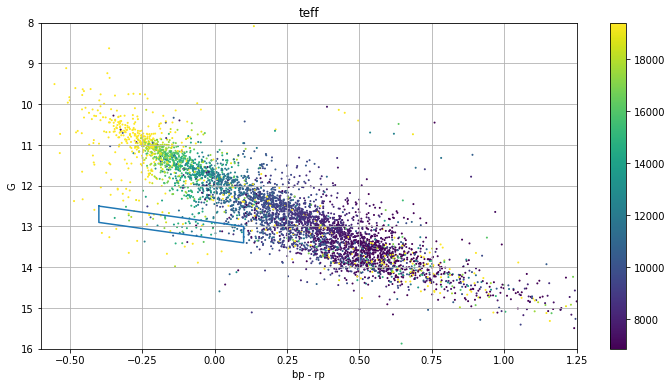

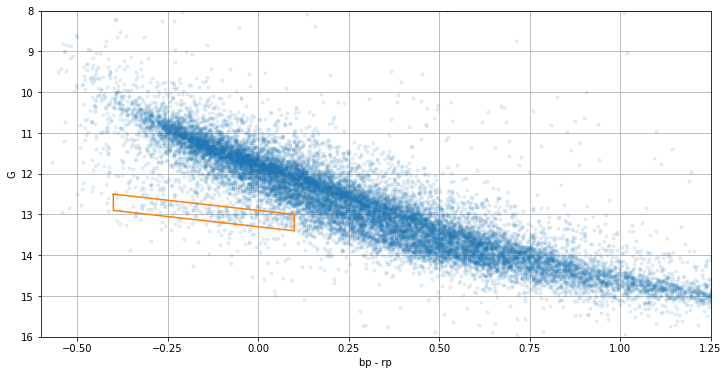

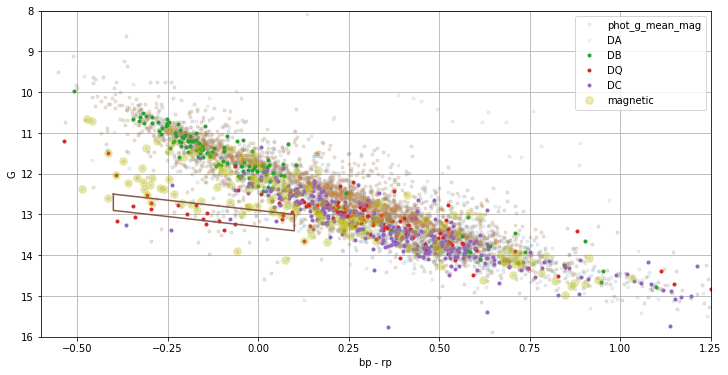

In [1362]:
plt_list = ['DA','DB','DQ','DC','mag']
high_snr = (WD_with_spec['parallax_over_error']>10)
plot_HR(WD_with_spec[high_snr],func,func_select,plt_list,'teff',plt_box=True)
plot_HR(WD_sdss,func,func_select,plt_list,True,plt_box=True)
selected_low = plot_HR(WD_with_spec,func,func_select,plt_list)

In [1363]:
for i in range(selected_low.sum()):
    print(WD_with_spec[selected_low]['name'][i])

SDSS J083602.91+303149.7
SDSS J110752.87-160705.4
SDSS J090707.34+253313.46
SDSS_J004705.83-004819.6
SDSS J112322.47+602940.06
SDSS J114250.22+001434.98
SDSS J151314.08+545420.5
SDSS J113359.94+633113.2
SDSS J114006.35+182402.3
SDSS J225828.49+280829.04
SDSS J004511.95+250330.9
SDSS J091440.38+111336.2
SDSS J150451.72+052140.82
SDSS J141309.30+191832.0
SDSS J093054.57-012642.94
SDSS J120331.90+645101.3
SDSS_J094225.66+401105.2
SDSS J135107.00+074345.66
SDSS J104906.61+165923.75
SDSS J140247.98+120410.92
SDSS J134946.37+125613.52
SDSS J072724.66+403622.0
SDSS_J113156.19+534654.1
SDSS J080042.48+065542.1
SDSS_J110217.13+541954.0
SDSS_J084717.71+322209.4
SDSS_J165407.32+195623.8
SDSS J141251.04+140104.01
SDSS J100932.73+524638.2
SDSS J110604.52+180231.27
SDSS J110058.04+175807.0
SDSS J224459.62+331017.40
SDSS J144854.80+051903.54
SDSS J142812.54+323817.7
SDSS J150716.29+070654.77
SDSS J100759.80+162349.6
SDSS J151130.20+422023.0
SDSS J095837.00+585303.01
SDSS J150318.12+075718.02
SDSS_J12

In [1391]:
print(np.where(WD_sdss['name'] == 'SDSS J144707.42+585506.7'))
WD_sdss[np.where(WD_sdss['name'] == 'SDSS J144707.42+585506.7')]

(array([17155]),)


<Table masked=True length=1>
    solution_id             designation          ...   mass   Dmass 
                                                 ...                
       int64                   object            ... float64 float64
------------------- ---------------------------- ... ------- -------
1635721458409799680 Gaia DR2 1617015089130028544 ...    1.12    0.06

In [1381]:
MMDD[35615]

<Row index=35615 masked=True>
    wdid              name              icrsra     icrsdec   spectype   teff   Dteff    logg   Dlogg    mass   Dmass  ismag    su       sg       sr       si       sz     nbUV nbOpt       ra           dec     
   str30             str25              str11       str12     str72   float64 float64 float64 float64 float64 float64  str3 float64  float64  float64  float64  float64  int64 int64    float64       float64   
----------- ------------------------ ----------- ----------- -------- ------- ------- ------- ------- ------- ------- ----- -------- -------- -------- -------- -------- ----- ----- ------------- -------------
WD 1445+591 SDSS J144707.42+585506.7 14 47 07.42 58 55 06.77       DA 17600.0   870.0    8.82    0.11    1.12    0.06    -- 19.21802 19.05458 19.32452 19.53111 19.72042     0     1 221.780916667 58.9185472222

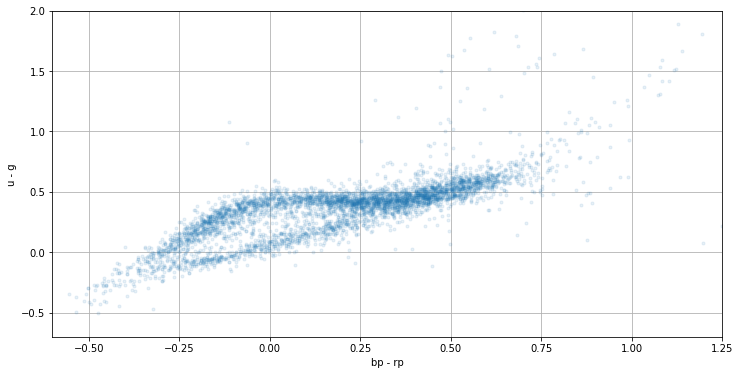

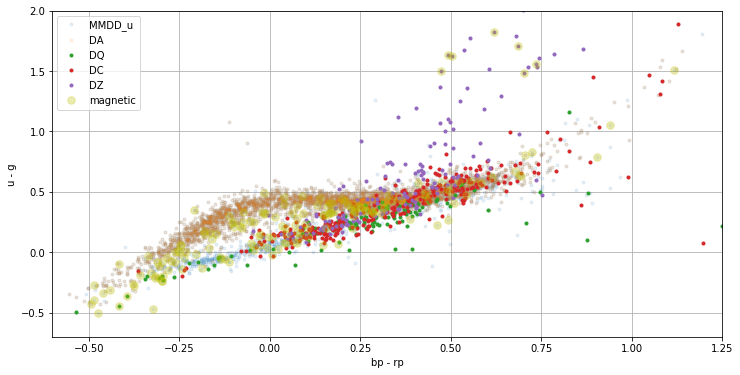

masked_BaseColumn(data = [False False False ..., False False False],
                  mask = False,
            fill_value = 1e+20)

In [1336]:
plt_list = ['DA','DQ','DC','DZ','mag']
high_snr = (WD_sdss['parallax_over_error']>10)
plot_HR(WD_sdss[small_d*high_snr],func,func_select,plt_list,True,'CC')
plot_HR(WD_sdss[small_d*high_snr],func,func_select,plt_list,False,'CC')

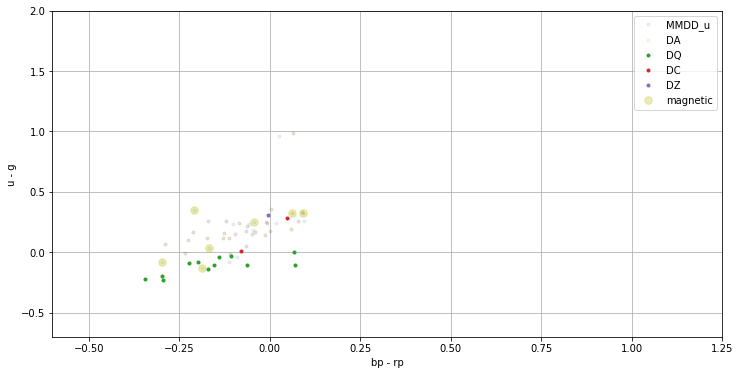

masked_BaseColumn(data = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False],
                  mask = False,
            fill_value = 1e+20)

In [1268]:
plt_list = ['DA','DQ','DC','DZ','mag']
table = WD_with_spec_selected_low
plot_HR(table,func,func_select,plt_list,False,'CC')

In [1369]:
def plot_spec(table,spec,selected,element=['H','He','C','Na']):
    n = selected.sum()
    spec_selected = spec[selected,:]
    WD_with_spec_selected = WD_with_spec[selected].copy()
    WD_with_spec_selected['spec_index'] = np.arange(n)
    #WD_with_spec_selected.sort('bp_rp')
    index = WD_with_spec_selected['spec_index']
    print(n)
    fig, axes = plt.subplots(n,1, sharex='col',figsize=(18,n*1.5))
    ismag_text = np.array(WD_with_spec_selected['ismag'])
    for i in range(n):
        if 'H' in element:
            axes[i].axvline(6563)
            axes[i].axvline(4861.3615)
            axes[i].axvline(4340.462)
        if 'Na' in element:
            axes[i].axvline(5893,c='y')
        if 'He' in element:
            axes[i].axvline(5875.62,c='r')
            axes[i].axvline(6678.15,c='r')
            axes[i].axvline(5015.67,c='r')
            axes[i].axvline(4921.93,c='r')
            axes[i].axvline(4713.14,c='r')
            axes[i].axvline(4471.48,c='r')
        if 'C' in element:
            axes[i].axvline(5170.462,c='b')
        axes[i].plot(lam_standard,spec_selected[index[i],:]/spec_selected[index[i],:].mean())
        axes[i].text(7000,1,WD_with_spec_selected['name'][i]+' '+WD_with_spec_selected['spectype'][i]+\
                    ' '+ismag_text[i]+'  '+'%.2f' % WD_with_spec_selected['bp_rp'][i]+' '+\
                    '%i' % WD_with_spec_selected['teff'][i]+' '+'%.3f' % WD_with_spec_selected['MMDD_d'][i] )
        axes[i].set_ylim(0,3)
    plt.show()

57


/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


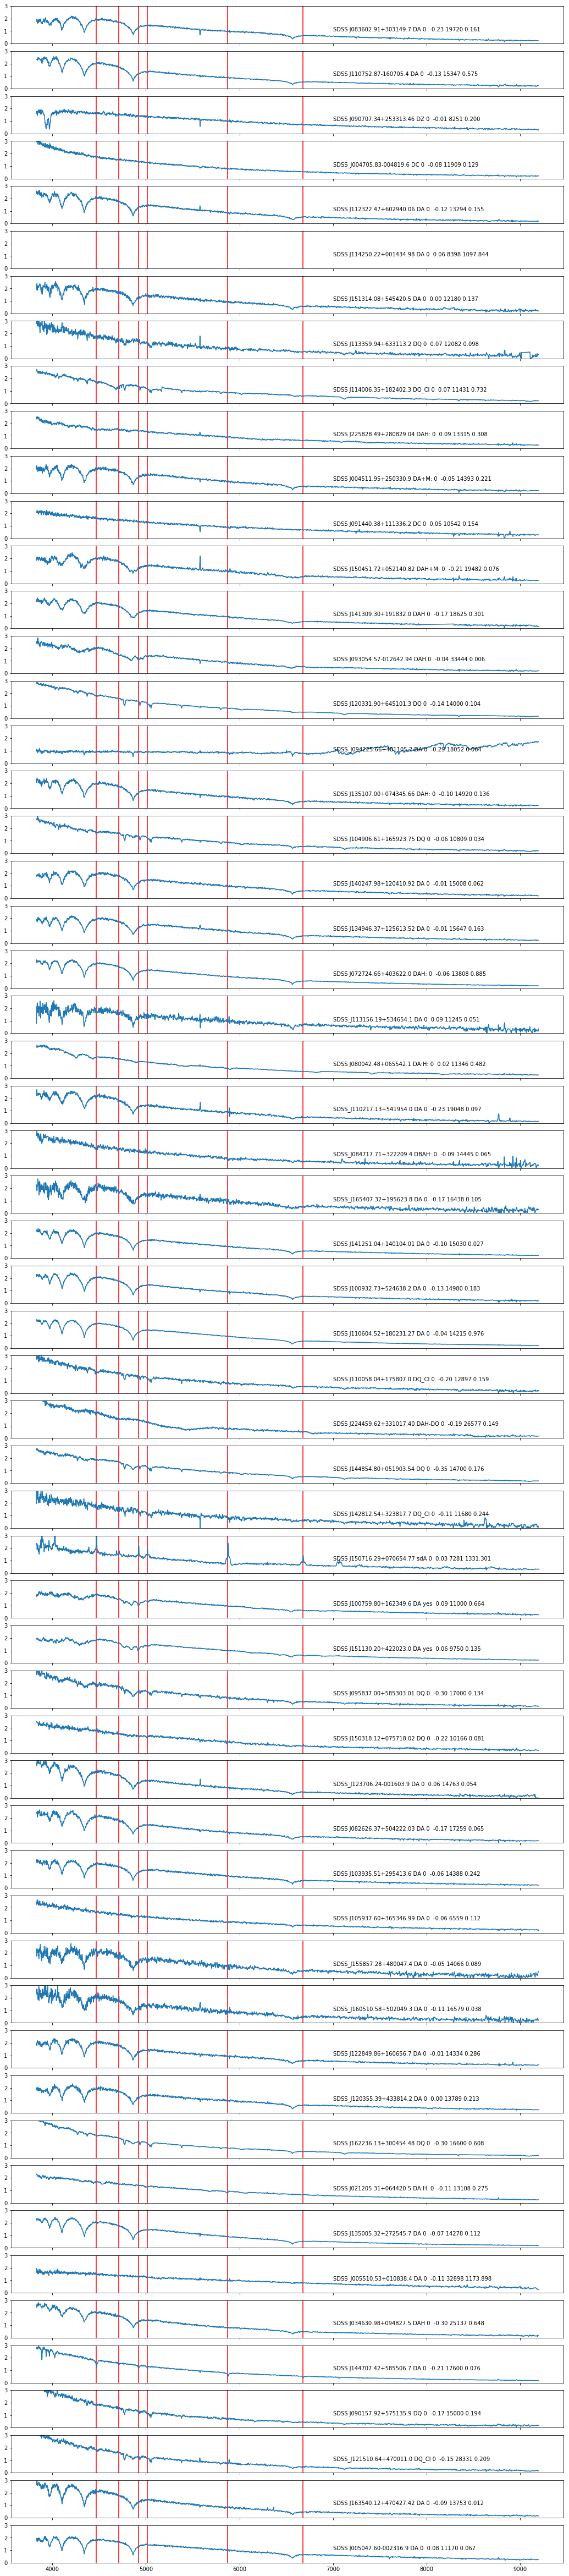

In [1370]:
plot_spec(WD_with_spec,spec,selected_low,['He'])

2


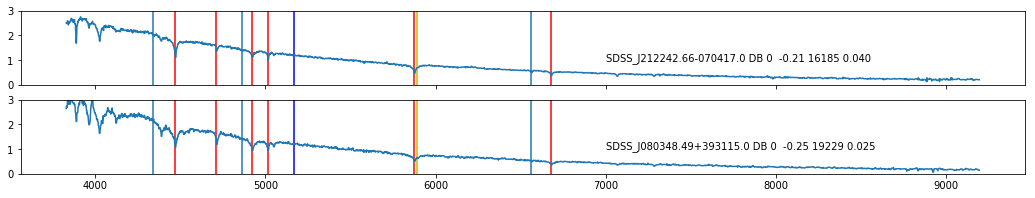

In [1371]:
plot_spec(WD_with_spec,spec,(WD_with_spec['spectype']=='DB')*(WD_with_spec['index']<200))

In [1351]:
WD_with_spec[np.where((WD_with_spec['spectype']=='DB')*())[0][0:10]]

<Table masked=True length=10>
    solution_id             designation          ...     spec_G    
                                                 ...               
       int64                   object            ...    float64    
------------------- ---------------------------- ... --------------
1635721458409799680 Gaia DR2 6898954221799625984 ... -12.2706517924
1635721458409799680  Gaia DR2 921092127886511360 ... -12.7440404172
1635721458409799680   Gaia DR2 77504888175094272 ... -11.6200727555
1635721458409799680 Gaia DR2 4464716326367334528 ... -12.6759253114
1635721458409799680  Gaia DR2 943832772831902592 ... -11.5734496125
1635721458409799680  Gaia DR2 817590730381121920 ... -10.3373612111
1635721458409799680 Gaia DR2 1620300880845914496 ... -12.6688161527
1635721458409799680 Gaia DR2 1658742551836692736 ... -12.3544408136
1635721458409799680 Gaia DR2 1742723902801586816 ... -11.0606496696
1635721458409799680 Gaia DR2 2678721796291234560 ... -11.6513663528

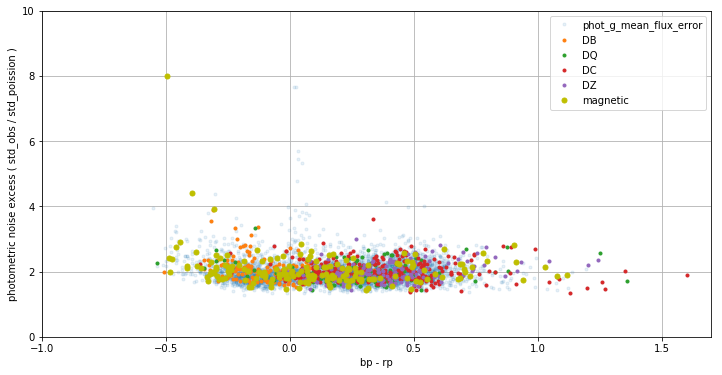

masked_BaseColumn(data = [False False False ..., False False False],
                  mask = False,
            fill_value = 1e+20)

In [1163]:
plot_HR(WD_sdss[small_d],func,func_select,False,'Var')

# PCA

In [413]:
from sklearn.decomposition import PCA
def pca_analysis(vectors, x, n_component = 5,pl=[1,1,1,1,1]):
    pca = PCA(n_components = n_component,whiten=True)
    pca.fit(vectors)
    if pl[0]==True:
        plt.plot(pca.explained_variance_ratio_,'.-')
        plt.show()
        print(pca.explained_variance_ratio_)
    if pl[1]==True:
        plt.plot(x, pca.inverse_transform(np.zeros(n_component)))  
        plt.show()
    if pl[2]==True:
        plt.figure(figsize=(12,24))
        for i in range(n_component):
            plt.subplot(10,2,i+1)
            vector = np.zeros(n_component)
            vector[i] = 1
            plt.plot(x, pca.inverse_transform(vector))  
        plt.show()
    components = pca.transform(vectors)
    if pl[3]==True:
        plt.figure(figsize=(18,18))
        for j in range(n_component):
            for i in range(n_component):
                plt.subplot(n_component,n_component,i+1+n_component*j)
                plt.plot(components[:,i],components[:,j],'.',alpha=0.05)
                #plt.plot(components[selected_a,i],components[selected_a,j],'.',alpha=0.05)
                #plt.plot(components[selected_b,i],components[selected_b,j],'.',alpha=0.05)
                plt.xlim(-4,4)
                plt.ylim(-4,4)
        plt.show()
    if pl[4]==True:
        plt.figure(figsize=(18,24))
        for i in range(80):
            plt.subplot(16,5,i+1)
            plt.plot(x,vectors[i,:])
            plt.plot(x,vectors[i,:] - pca.inverse_transform(components[i]))
        plt.show()
    return pca, components

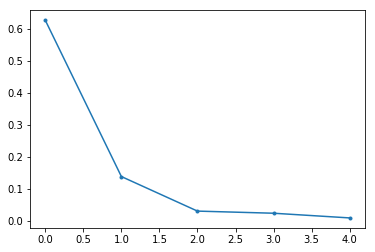

[ 0.62737575  0.13871403  0.03069538  0.02404596  0.00939774]


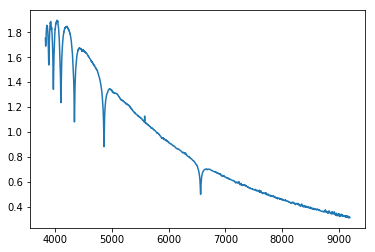

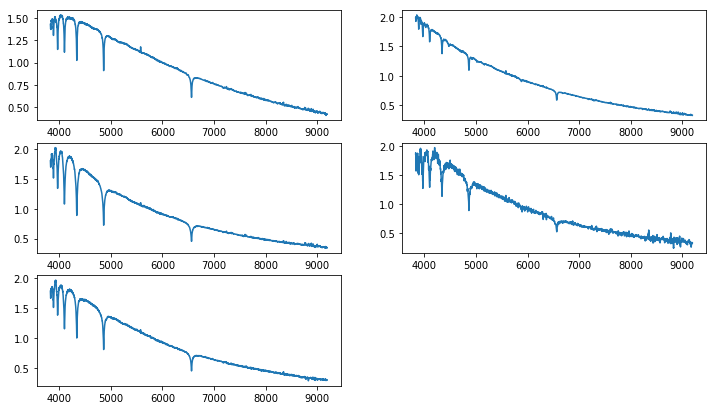

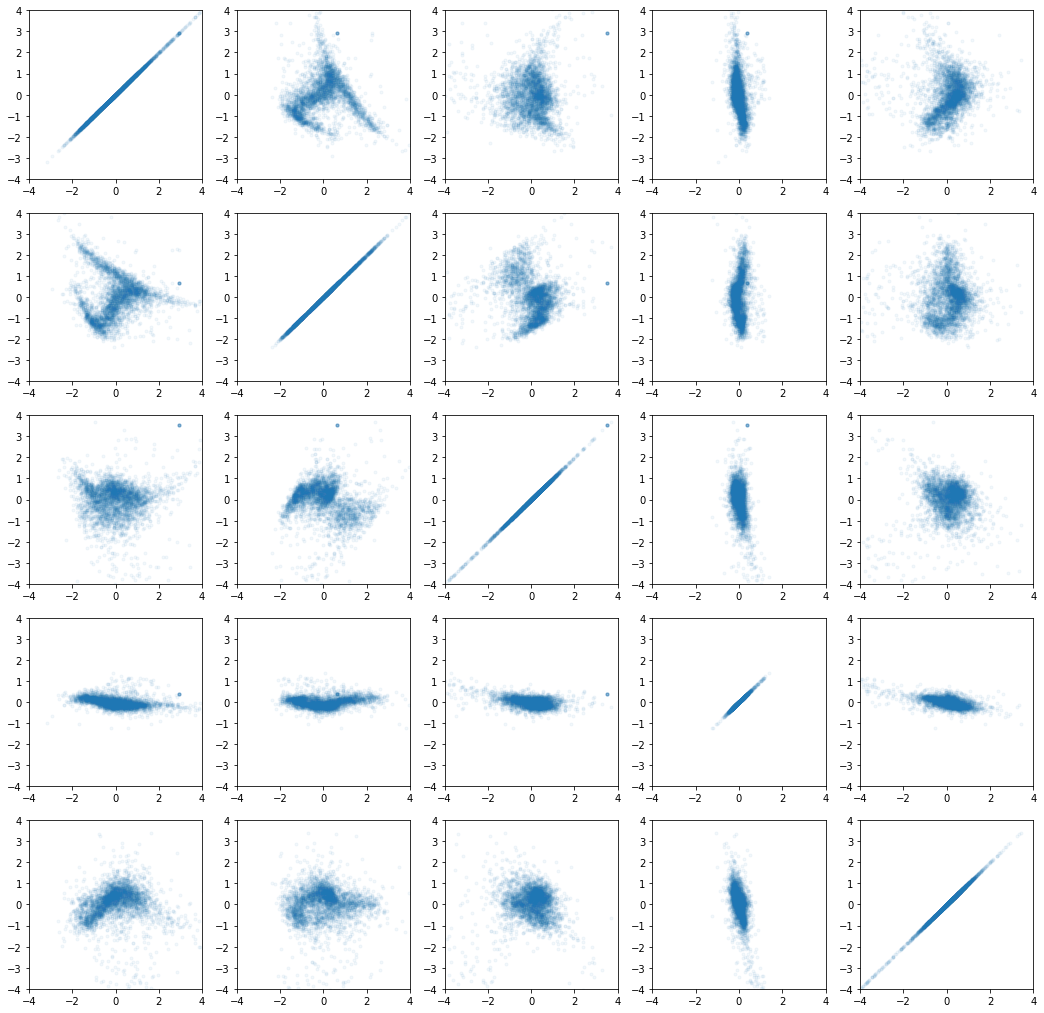

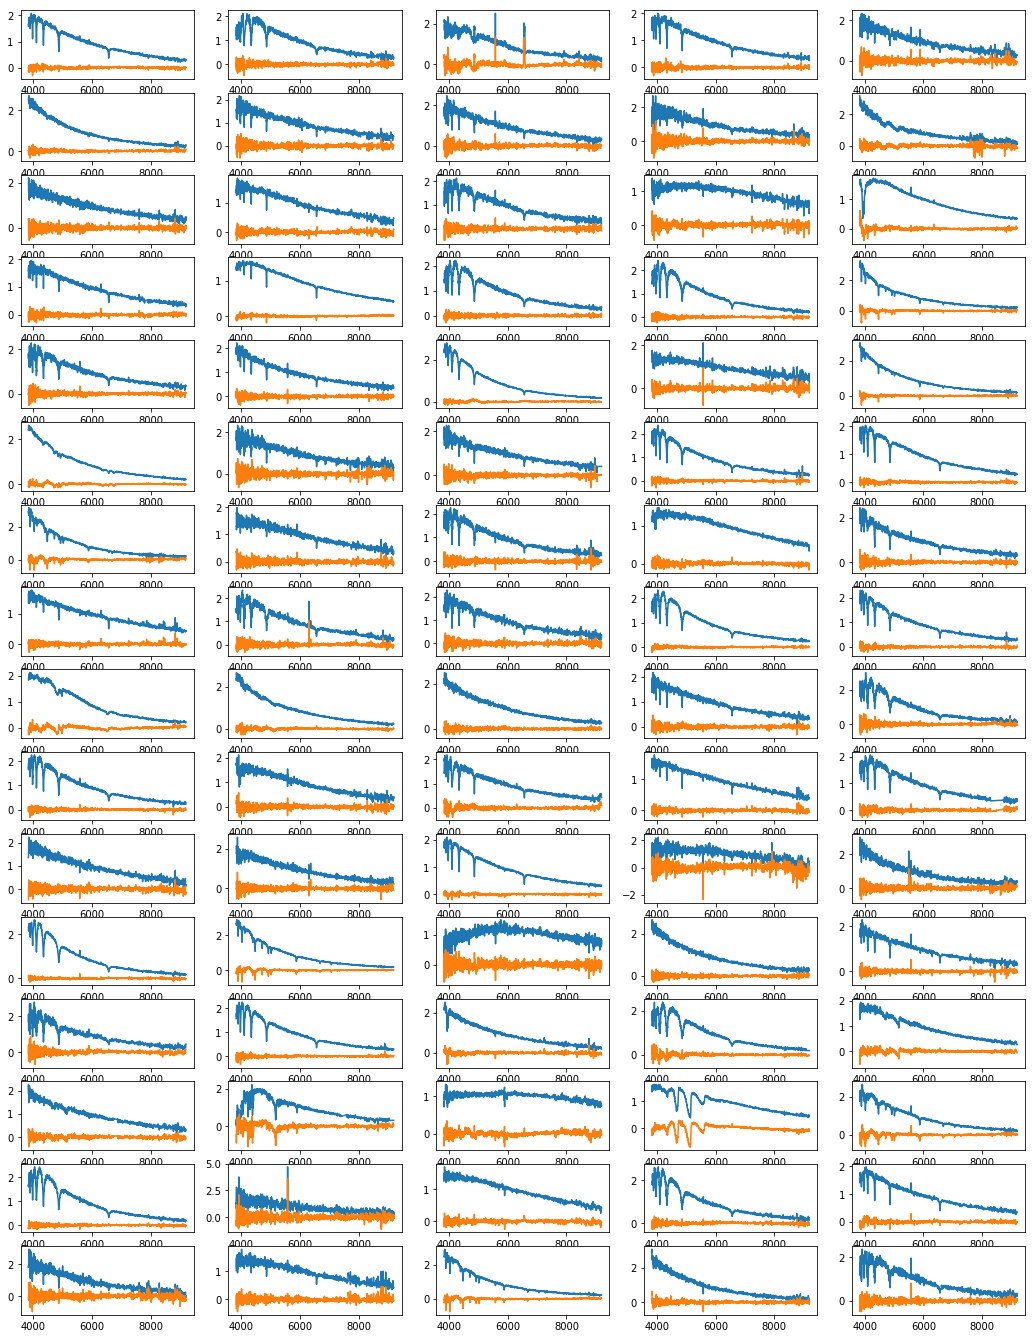

In [445]:
pca_all,_ = pca_analysis(spec, lam_standard, 5)

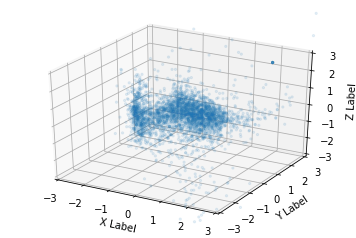

In [340]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = components[:,0]
y = components[:,1]
z = components[:,2]
ax.scatter(x, y, z, marker='.',alpha=0.1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim(-3,3)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
plt.show()

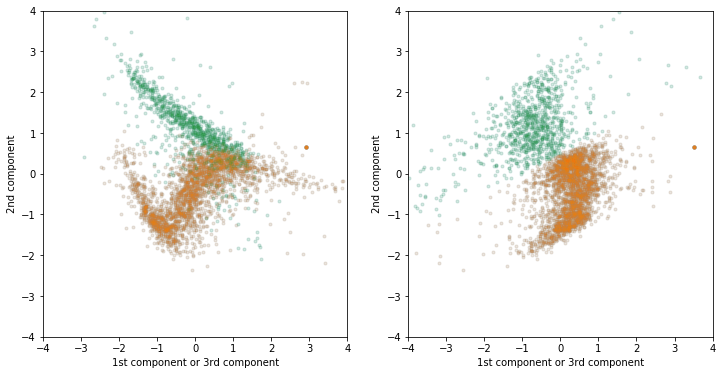

In [373]:
selected_b = (components[:,1] + components[:,0]*4/4 > 0.7) * \
            ~((components[:,2]<1.5)*(components[:,1] - components[:,2]*2/4 < 0.5)*(components[:,2]>-1))
selected_b = ~(components[:,1] - components[:,2]*2/4 < 0.5)

selected_a = (components[:,1] + components[:,0]*3/2 < -2)
selected_a =  ~selected_b

plt.figure(figsize=(12,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(components[:,i*2],components[:,1],'.',alpha=0.1)
    plt.plot(components[:,i*2][selected_a],components[:,1][selected_a],'.',alpha=0.1)
    plt.plot(components[:,i*2][selected_b],components[:,1][selected_b],'.',alpha=0.1)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.xlabel('1st component or 3rd component')
    plt.ylabel('2nd component')
plt.show()

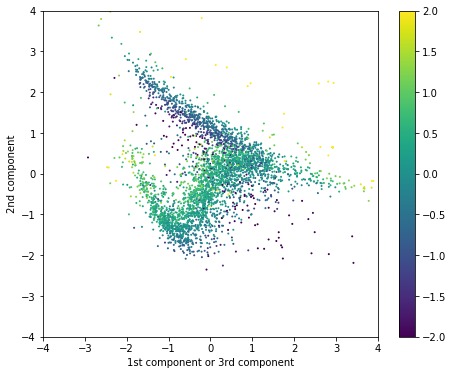

In [349]:
plt.figure(figsize=(7.5,6))
plt.scatter(components[:,0],components[:,1],c=components[:,2],s=1,vmin=-2,vmax=2)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel('1st component or 3rd component')
plt.ylabel('2nd component')
plt.colorbar()
plt.show()

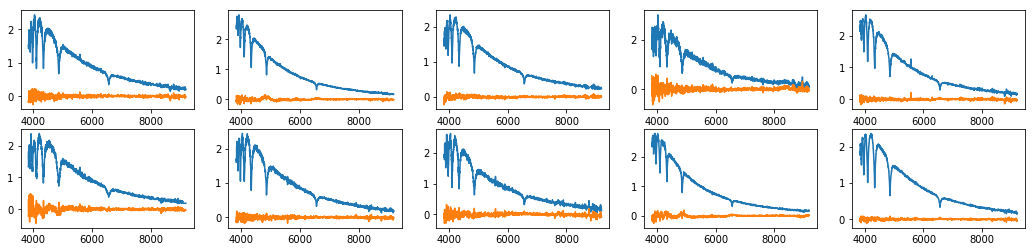

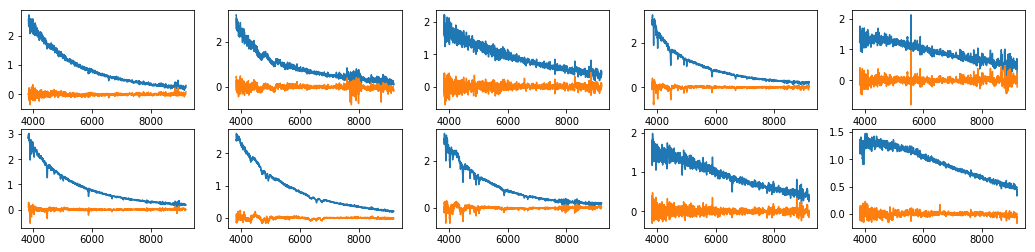

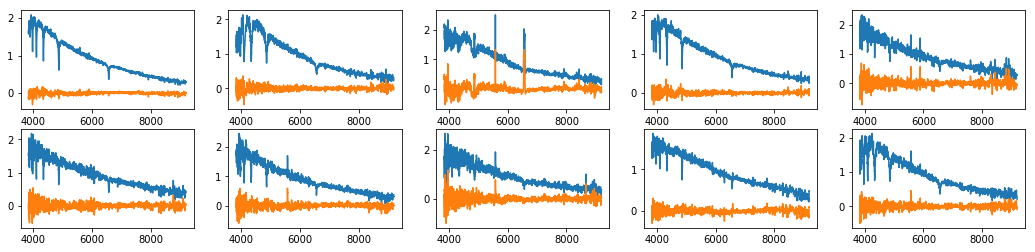

In [359]:
selected = selected_a
for selected in [selected_a,selected_b,selected_c]:
    plt.figure(figsize=(18,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.plot(lam_standard,spec[selected][i,:])
        plt.plot(lam_standard,spec[selected][i,:] - pca.inverse_transform(components[selected][i]))
    plt.show()

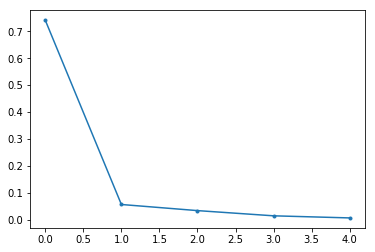

[ 0.74051337  0.05783607  0.03518464  0.01588338  0.00810285]


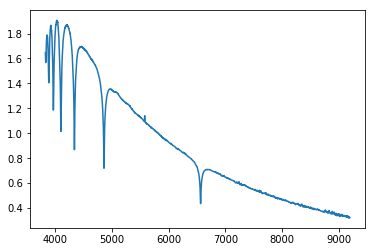

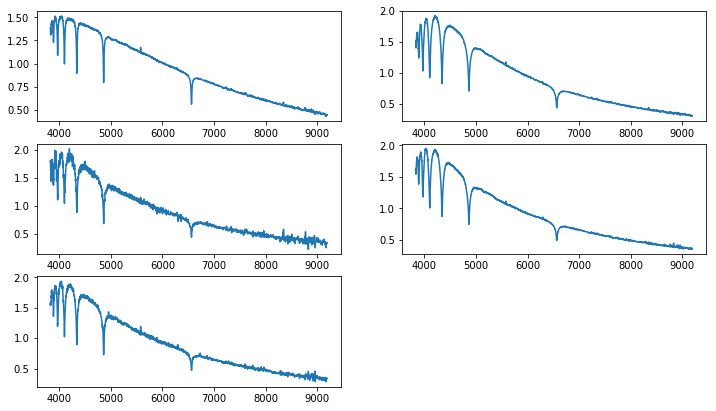

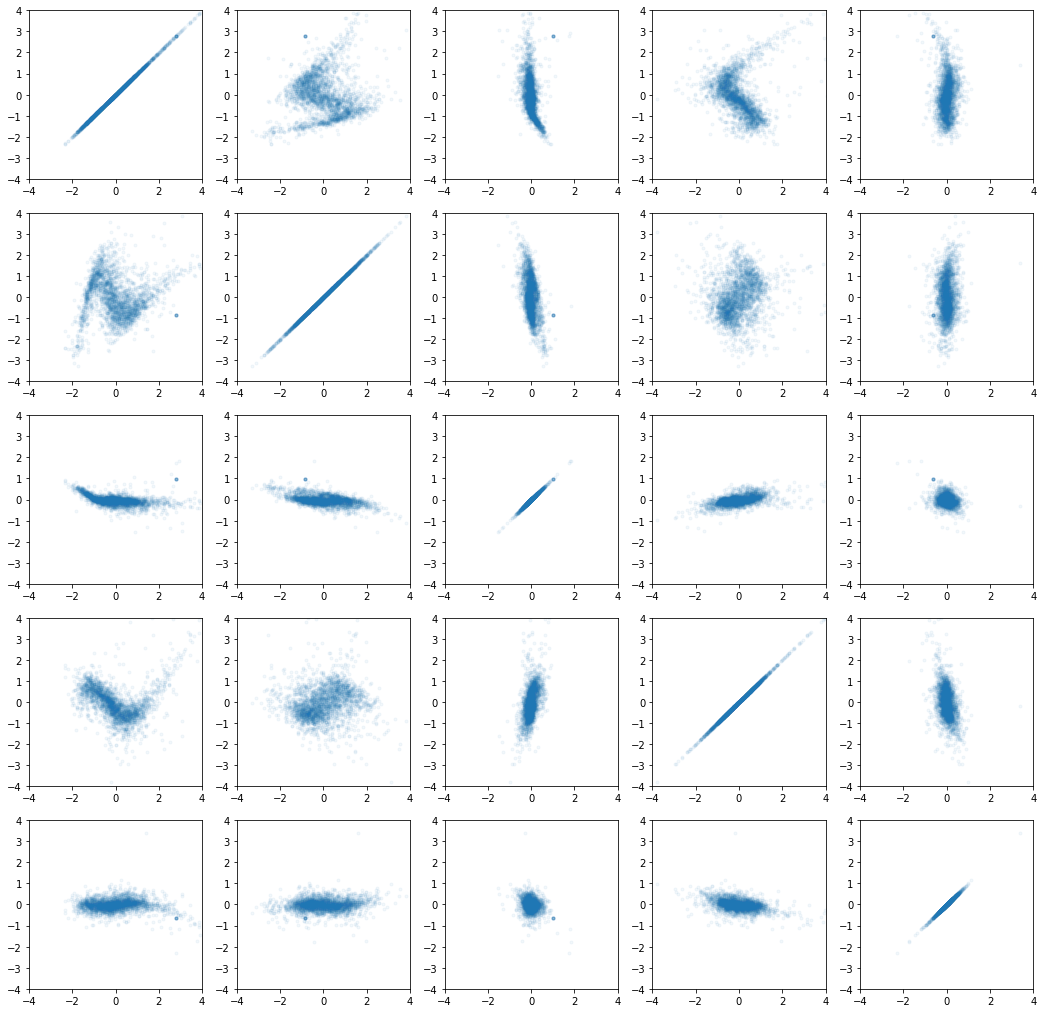

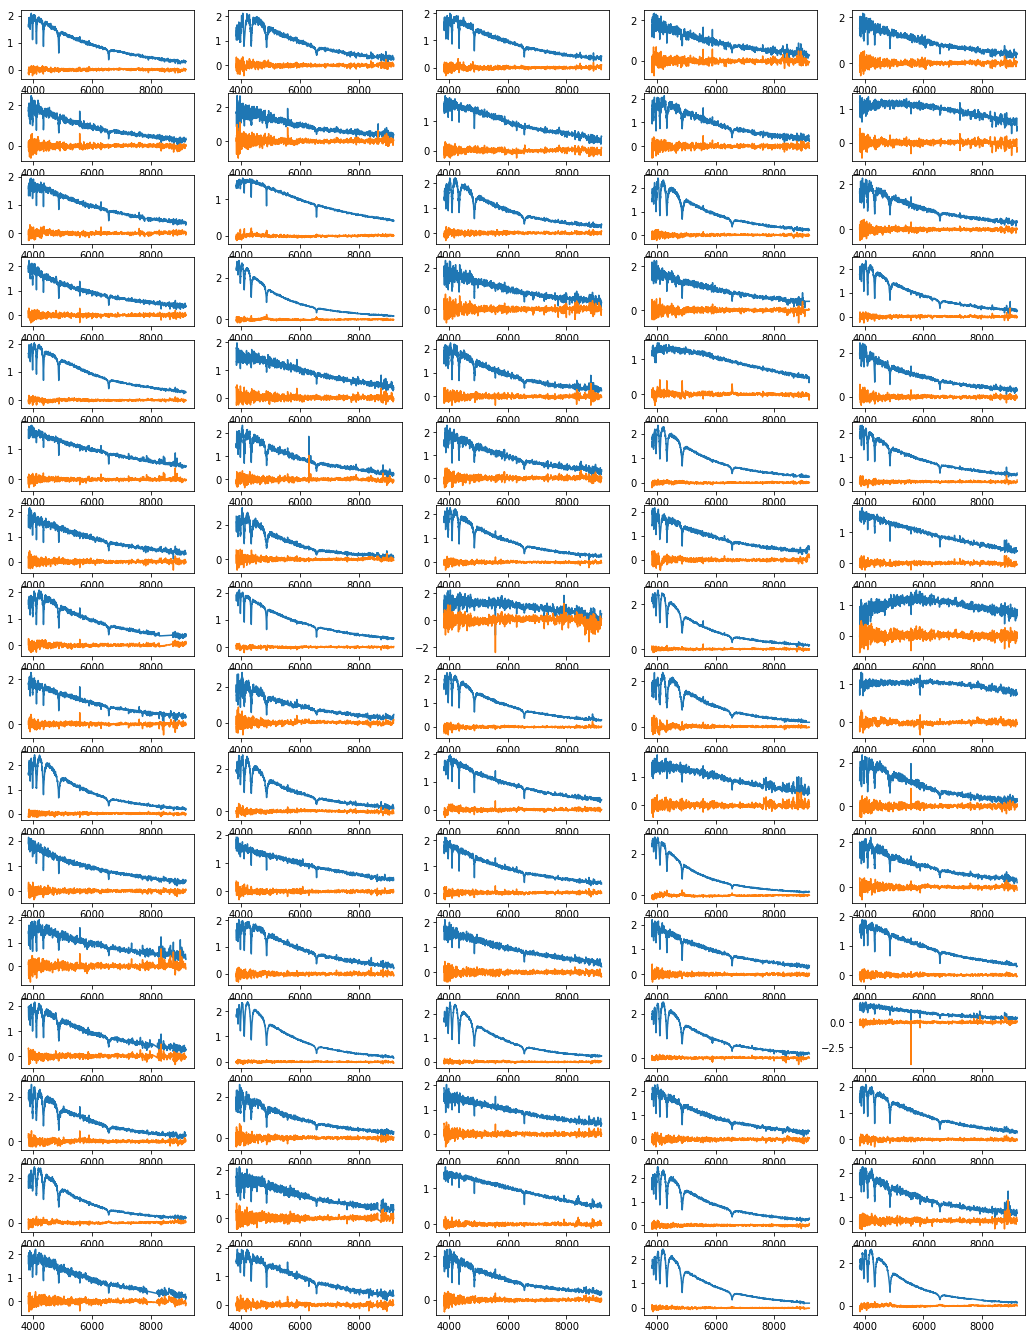

In [417]:
pca_A,_ = pca_analysis(spec[selected_a], lam_standard, 5)

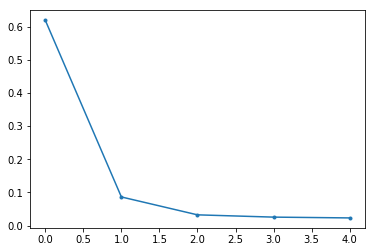

[ 0.61918675  0.08626875  0.03232331  0.02546297  0.02306365]


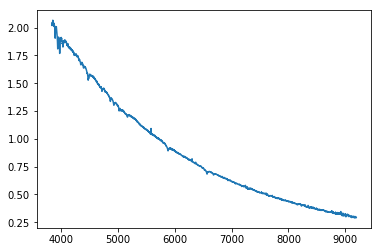

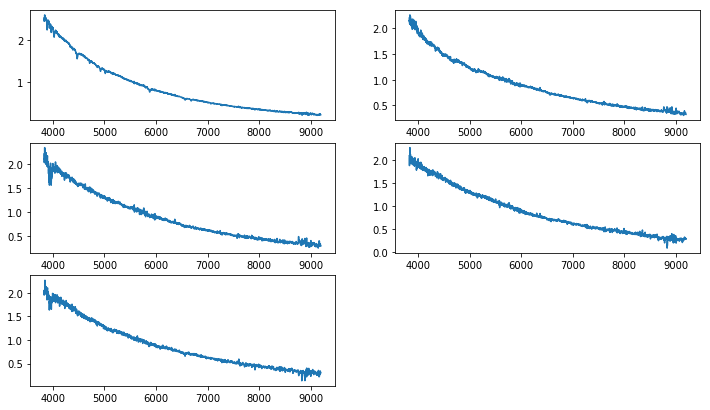

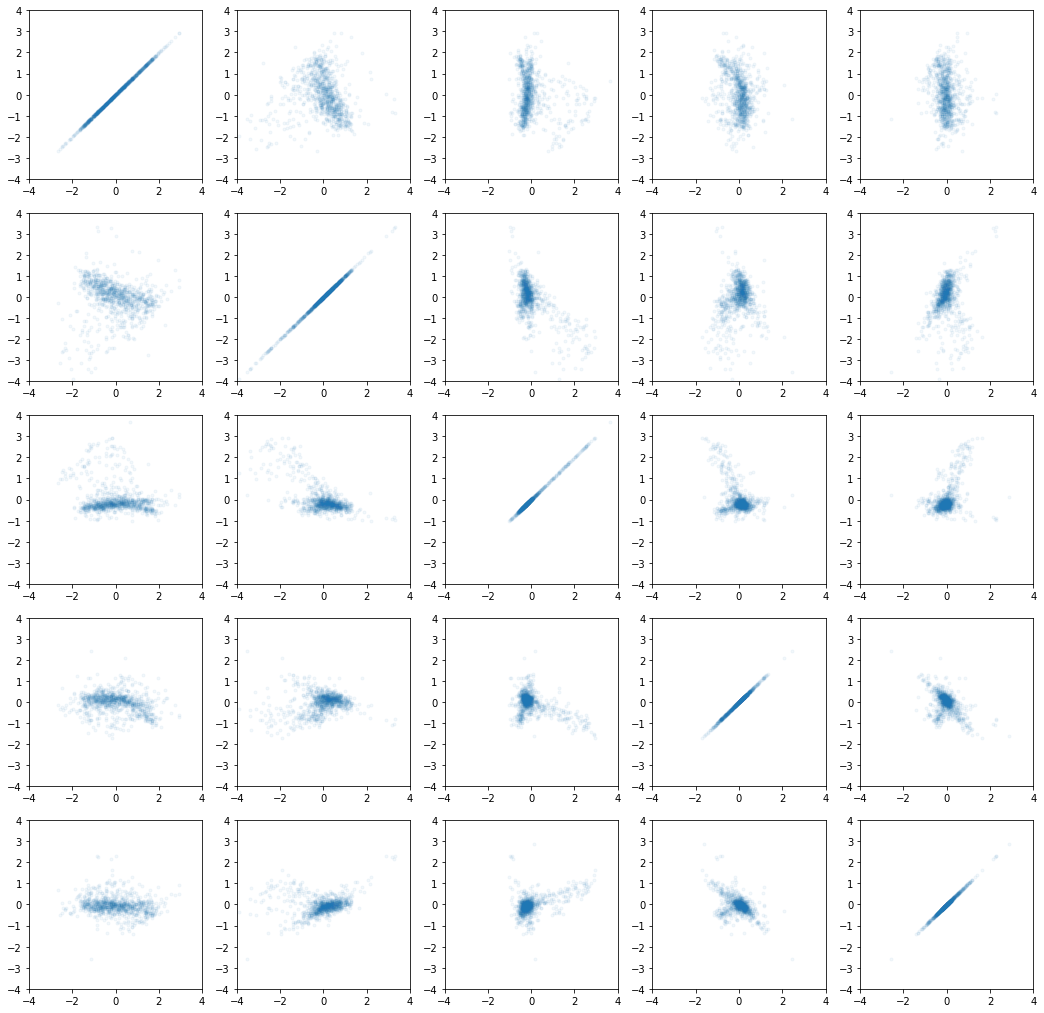

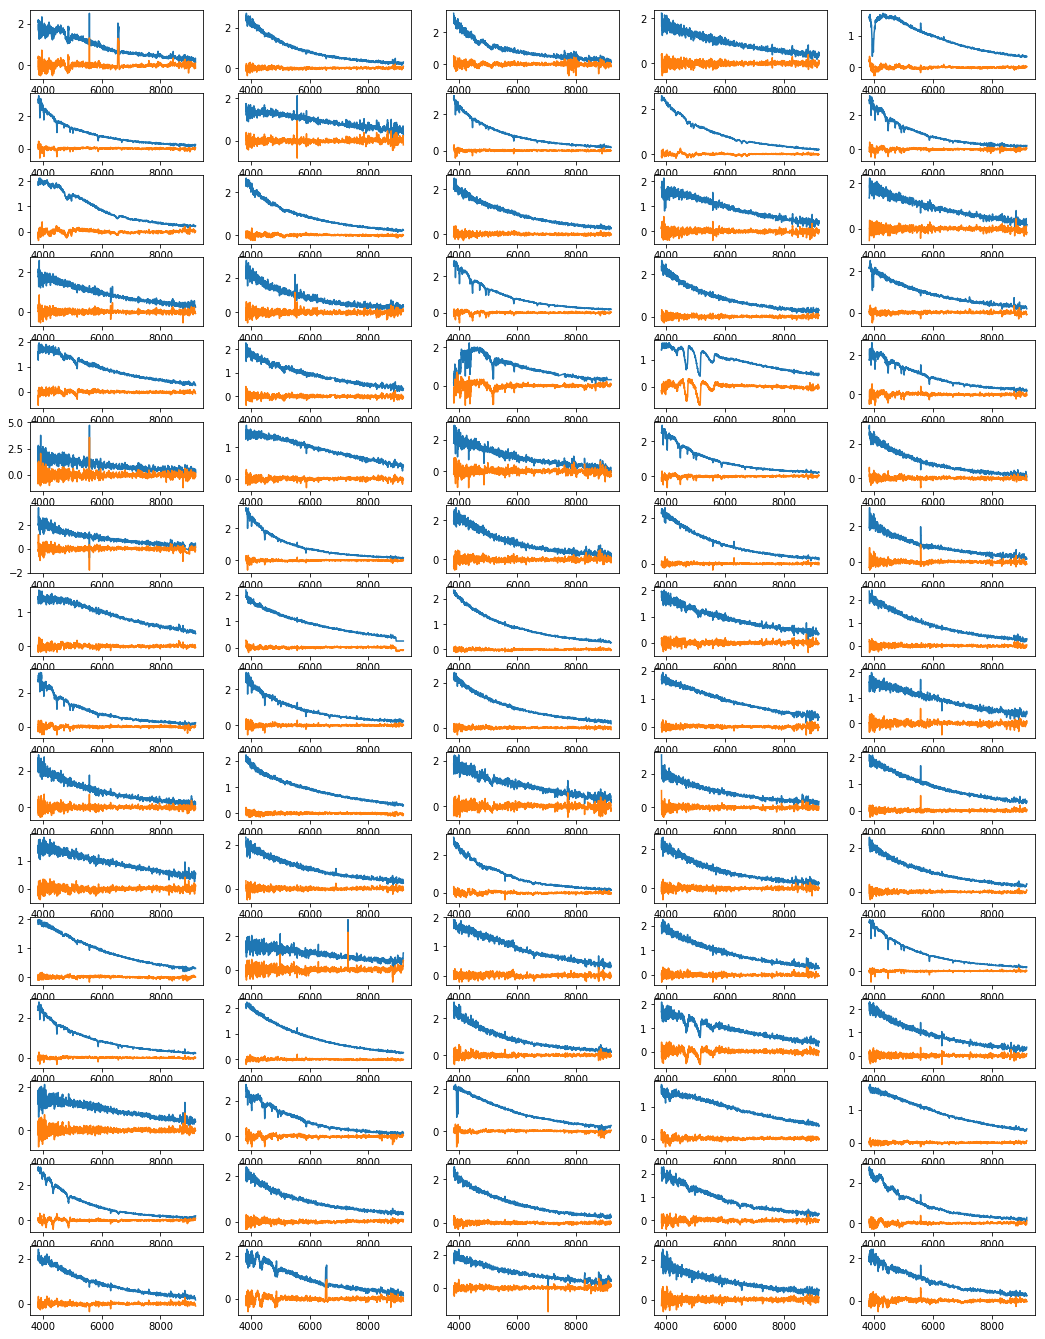

In [418]:
pca_B,_ = pca_analysis(spec[selected_b], lam_standard, 5)

In [549]:
spec[selected_b].shape

(946, 3803)

In [559]:
selected = pca_B.transform(spec[selected_b])[:,2]>0.5
selected = np.where(selected_b)[0][selected]
selected.size

108

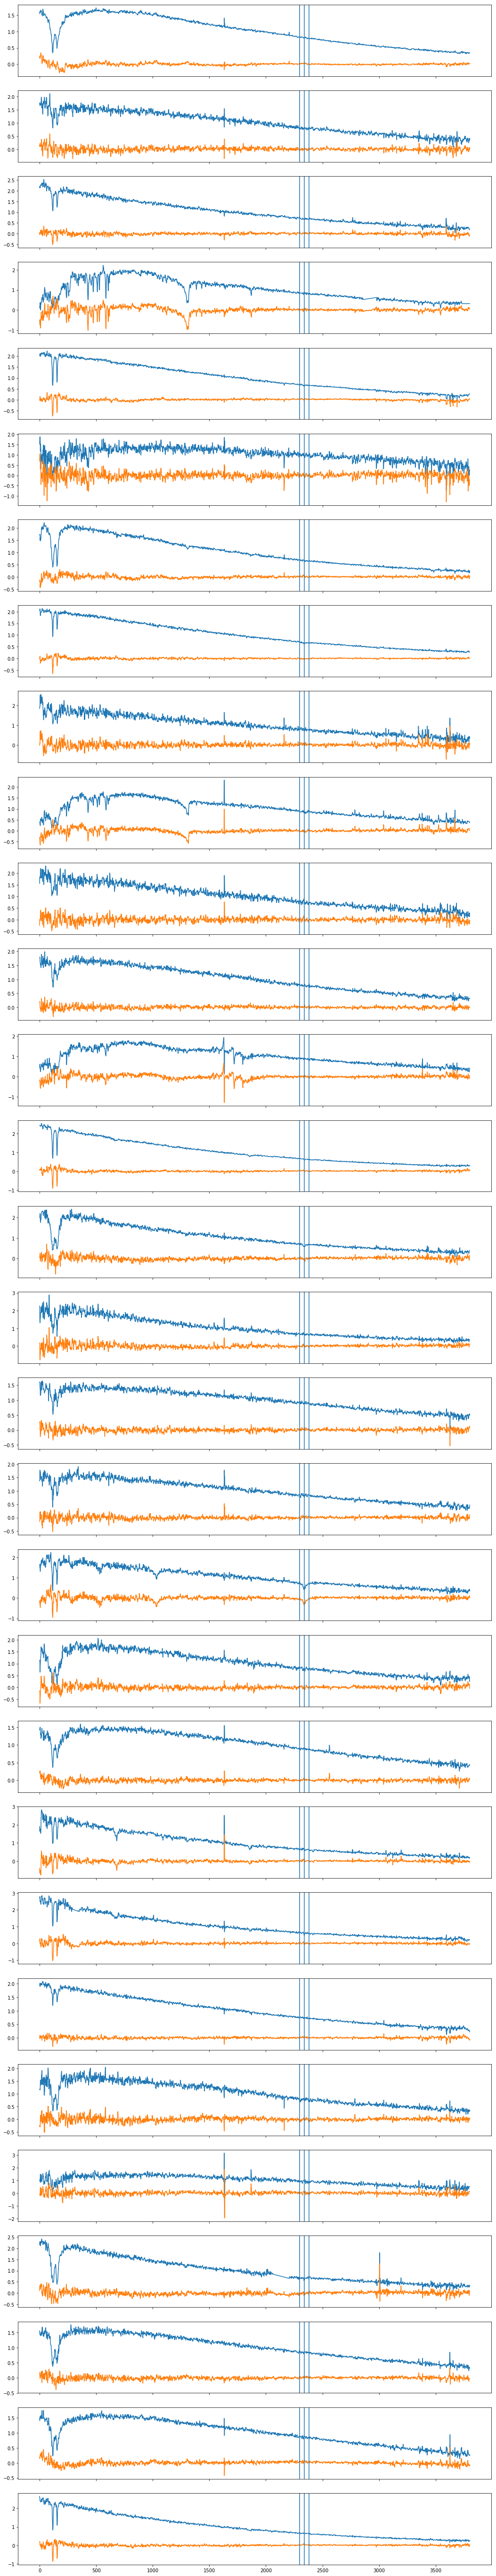

In [562]:
pca = pca_B
n = 30
components = pca.transform(spec[selected,:])
fig, axes = plt.subplots(n,1, sharex='col',figsize=(18,100))
for i in range(n):
    axes[i].plot(spec[selected[i],:])
    axes[i].plot(spec[selected[i],:] - pca.inverse_transform(components[i]))
    axes[i].axvline(2340)
    axes[i].axvline(2380)
    axes[i].axvline(2300)
plt.show()

(array([   3,  112,  160,  197,  243,  254,  353,  484,  572,  574,  600,
        645,  701,  720,  721,  859,  863,  961, 1159, 1335, 1450, 1638,
       2327, 2601, 2887, 2899, 2989]),)


/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/scheng/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


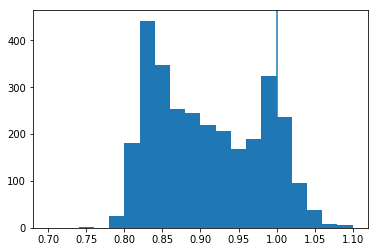

In [636]:
H_alpha = spec[index,2300:2380].sum(axis=1) /80 / (spec[index,2300]+spec[index,2380]) * 2 * 0.4 + \
                    spec[index,985:1085].sum(axis=1)/100 / (spec[index,985]+spec[index,1085]) * 2 * 0.6
#H_alpha = spec[:,2340] / (spec[:,2300]+spec[:,2380]) * 2 * 0.4 + spec[:,1035] / (spec[:,985]+spec[:,1085]) * 2 * 0.6

DB = np.abs(H_alpha-0.99)<0.02
DA = H_alpha<0.80
#print(np.where(DA))
print(np.where(DA))
plt.hist(H_alpha,20,(0.7,1.1))
plt.axvline(1)
plt.show()

In [627]:
H_alpha

array([ 84.89549742,  77.16727517,  91.40308147, ...,  84.0597393 ,
        75.26832672,  89.47278383])

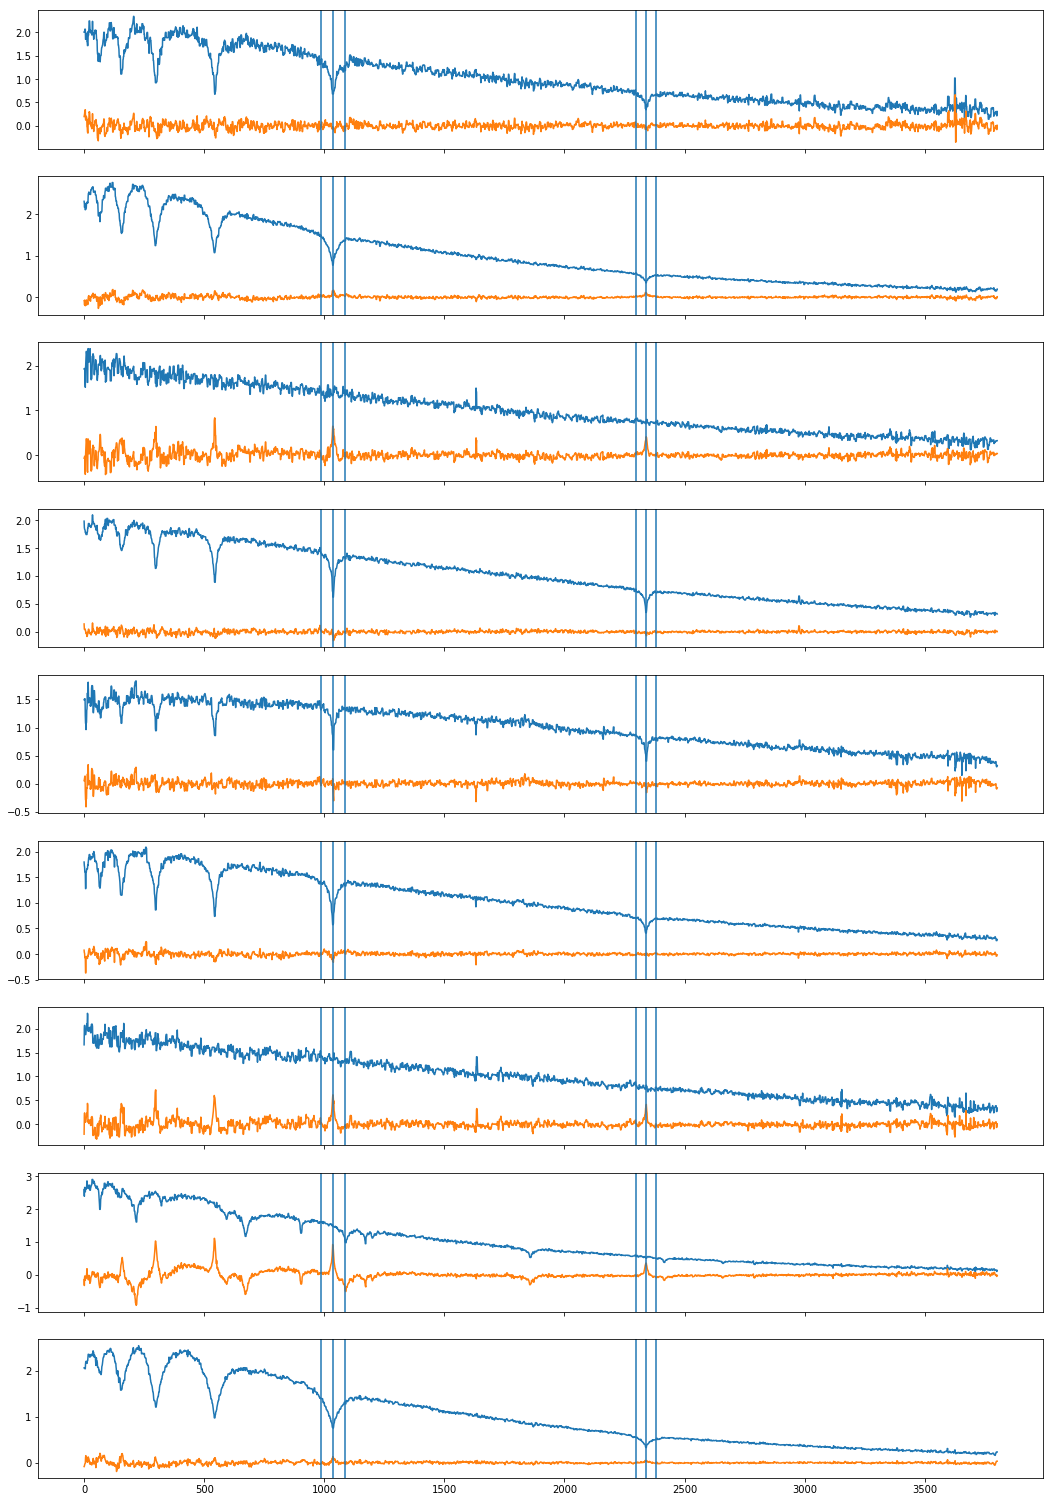

In [567]:
pca = pca_A
components = pca.transform(spec[index,:])
fig, axes = plt.subplots(9,1, sharex='col',figsize=(18,27))
for i in range(9):
    axes[i].plot(spec[index[i],:])
    axes[i].plot(spec[index[i],:] - pca.inverse_transform(components[i]))
    axes[i].axvline(2340)
    axes[i].axvline(2380)
    axes[i].axvline(2300)
    
    axes[i].axvline(1035)
    axes[i].axvline(985)
    axes[i].axvline(1085)
plt.show()

In [585]:
DB

array([False, False,  True, ...,  True,  True, False], dtype=bool)

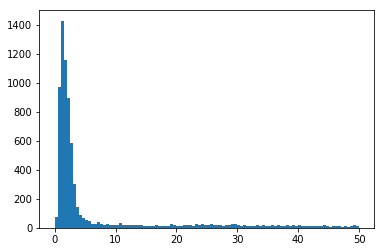

11788.235709 241


In [27]:
selected = (data['koi_steff']<3900)
factor = ((data['koi_period']/365)**(2/3)/data['koi_sma']**(1/3)*231/data['koi_srad'])
(factor[selected]).sum()
plt.hist(data['koi_prad'],range=(0,50),bins=100)
plt.show()
print((factor[selected*(factor<150)*(data['koi_prad']<4)]).sum(),selected.sum())

In [28]:
data = Table.read('cumulative.csv')
len(data)

7931